# Direct Collocation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from casadi import MX, DM, Function
import casadi as cas
from platform import python_version
from numpy.testing import assert_array_almost_equal
from lagrange_polynomial_eval import LagrangePolynomialEval
from direct_collocation_solutions import (
    sparse_system, 
    cas_integrator,
    explicit_integrator_rk4,
    ocp_multiple_shooting,
    make_polynomial_functions,
    ocp_direct_collocation,
    ocp_direct_collocation_coeffs,
    ocp_lifted_rk,
    process_timing
)

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.7
Python: 3.10.16


## 1. Direct Collocation

<img src="images/direct_collocation_1.png" width="50%">


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3528
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     2217

Total number of variables............................:      409
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      328
Total number of inequality c

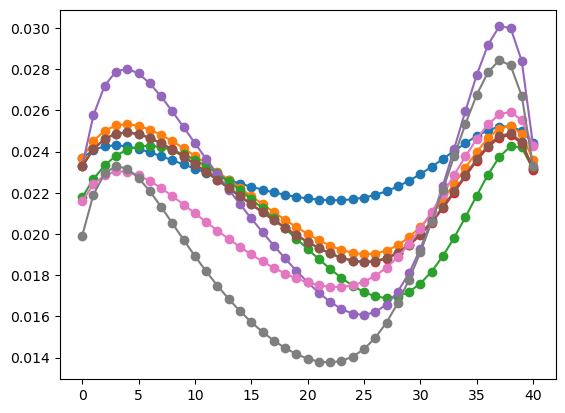

[0.0243962  0.02357921 0.02313442 0.02312336 0.02429731 0.02319165
 0.02428098 0.02328023]


In [2]:
# Run reference simulation
%run "sparse_system.py"

### 1.1. Timing information of IPOPT with RK integrator

Note down the timing information of IPOPT: `Total CPU secs in IPOPT (w/o function
evaluations)` and `Total CPU secs in NLP function evaluations`

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3528
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     2217

Total number of variables............................:      409
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      328
Total number of inequality constraints...............:      328
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      328
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1639980e-03 6.94e-18 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

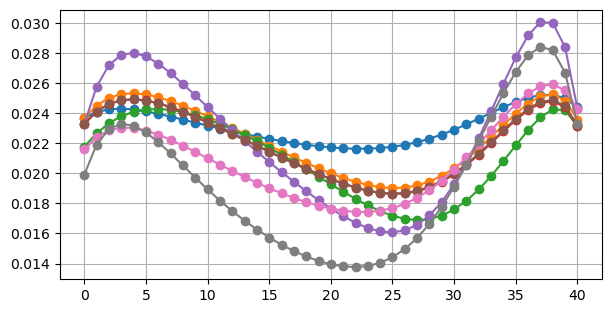

In [3]:
# My version of reference simulation
x, u, f, nx, nu, x_steady = sparse_system()

T = 1.0  # control horizon [s]
N = 40  # Number of control intervals
dt = T / N  # length of 1 control interval [s]

intg = cas_integrator(x, u, f, dt, solver='rk')

opti, X, U = ocp_multiple_shooting(nx, nu, N, intg, x_steady)
sol = opti.solve()
Xsol = sol.value(X)

plt.figure(figsize=(7, 3.5))
plt.plot(Xsol.T, 'o-')
plt.grid()
plt.show()

assert_array_almost_equal(
    sol.value(X[:, -1]), 
    [0.0243962, 0.02357921, 0.02313442, 0.02312336, 0.02429731, 0.02319165, 0.02428098, 0.02328023]
)

In [4]:
# CPU timing
timing_experiments = pd.DataFrame({"MS with RK intg": process_timing(sol)})
timing_experiments.round(3)

,MS with RK intg
t_proc_callback_fun,0.000
t_proc_nlp_f,0.000
t_proc_nlp_g,0.004
t_proc_nlp_grad,0.000
t_proc_nlp_grad_f,0.000
t_proc_nlp_hess_l,0.081
t_proc_nlp_jac_g,0.034
t_proc_total,0.173


### 1.2. Timing information of IPOPT with collocation integrator

Change the Runge-Kutta rk integrator to a collocation integrator. This runs a lot slower.
Can you explain?
Is the numerical result identical to the Runge-Kutta integrator?

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3528
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     2217

Total number of variables............................:      409
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      328
Total number of inequality constraints...............:      328
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      328
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1639980e-03 0.00e+00 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

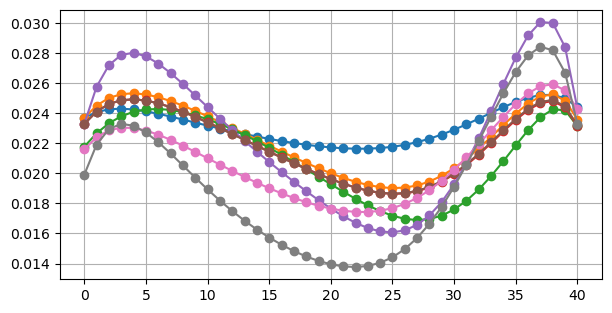

In [5]:
x, u, f, nx, nu, x_steady = sparse_system()

T = 1.0  # control horizon [s]
N = 40  # Number of control intervals
dt = T / N  # length of 1 control interval [s]

intg = cas_integrator(x, u, f, dt, solver='collocation')

opti, X, U = ocp_multiple_shooting(nx, nu, N, intg, x_steady)
sol = opti.solve()
Xsol = sol.value(X)

plt.figure(figsize=(7, 3.5))
plt.plot(Xsol.T, 'o-')
plt.grid()
plt.show()

assert_array_almost_equal(
    sol.value(X[:, -1]), 
    [0.0243962, 0.02357921, 0.02313442, 0.02312336, 0.02429731, 0.02319165, 0.02428098, 0.02328023]
)

In [6]:
# CPU timing
timing_experiments["MS with collocation intg"] = process_timing(sol)
timing_experiments.round(3)

,MS with RK intg,MS with collocation intg
t_proc_callback_fun,0.000,0.000
t_proc_nlp_f,0.000,0.000
t_proc_nlp_g,0.004,0.068
t_proc_nlp_grad,0.000,0.000
t_proc_nlp_grad_f,0.000,0.000
t_proc_nlp_hess_l,0.081,0.377
t_proc_nlp_jac_g,0.034,0.208
t_proc_total,0.173,0.710


Explanation:
- IPOPT with this collocation scheme is slower than with the Runge-Kutta integration scheme because it has to solve the additional rootfinding problems, which are part of the collocation method.  Thus it involves nested iterations, one iterative scheme (rootfinding) within another bigger iterative scheme.

### 1.3. Introduce extra decision variables for collocation

Introduce extra decision variables to accommodate for the helper states at the collocation points $X^c$. Do this inside the gap-closing for loop.


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9648
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     1057

Total number of variables............................:     1393
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1288
Total number of inequality constraints...............:      328
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      328
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1639980e-03 1.50e-15 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

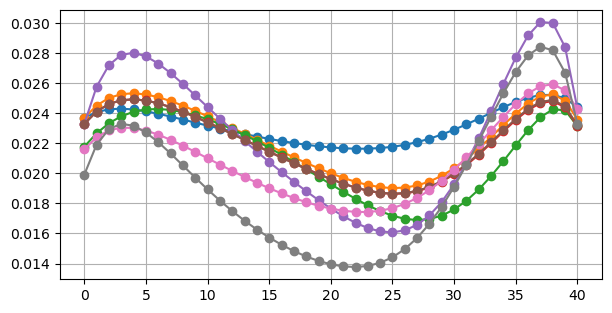

In [7]:
x, u, f, nx, nu, x_steady = sparse_system()

T = 1.0  # control horizon [s]
N = 40  # Number of control intervals
dt = T / N  # length of 1 control interval [s]

intg = cas_integrator(x, u, f, dt, solver='collocation')

# Collocation scheme
d = 3  # degree
scheme = 'radau'
tau = cas.collocation_points(d, scheme)
Pi, dot_Pi = make_polynomial_functions(nx, d)

opti, X, U = ocp_direct_collocation(
    f, nx, nu, N, dt, d, tau, Pi, dot_Pi, x_steady
)
sol = opti.solve()
Xsol = sol.value(X)

plt.figure(figsize=(7, 3.5))
plt.plot(Xsol.T, 'o-')
plt.grid()
plt.show()

assert_array_almost_equal(
    sol.value(X[:, -1]), 
    [0.0243962, 0.02357921, 0.02313442, 0.02312336, 0.02429731, 0.02319165, 0.02428098, 0.02328023]
)

In [8]:
# CPU timing
timing_experiments["Direct collocation Pi"] = process_timing(sol)
timing_experiments.round(3)

,MS with RK intg,MS with collocation intg,Direct collocation Pi
t_proc_callback_fun,0.000,0.000,0.000
t_proc_nlp_f,0.000,0.000,0.000
t_proc_nlp_g,0.004,0.068,0.009
t_proc_nlp_grad,0.000,0.000,0.000
t_proc_nlp_grad_f,0.000,0.000,0.000
t_proc_nlp_hess_l,0.081,0.377,0.050
t_proc_nlp_jac_g,0.034,0.208,0.180
t_proc_total,0.173,0.710,0.474


### 1.4. Verify that $\Pi$ and therefore $\dot{\Pi}$ are in fact linear in the coefficients

Open up the reference solution for task 6 of the collocation integrator exercise. We had a CasADi Function $Pi$ for the Legendre polynomial exactly interpolating through initial state $X_0$ and collocation helper states $X_c$. Use is linear to verify that $Pi$ and therefore $\dot(Pi)$ are in fact linear in the coefficients.


In [9]:
# Solution from Part 11, Collocation Integrator, exercise notebook

# Parameters
t0 = 2
dt = 0.1
nx = 2
d = 4

# Define collocation times
tau = DM(cas.collocation_points(d, 'legendre')).T
t_coll = t0 + dt * tau
T = cas.horzcat(t0, t_coll)

# Define collocation points
X0 = MX.sym("X0", nx)
Xc = MX.sym("Xc", nx, d)
X = cas.horzcat(X0, Xc)

# Polynomial function
t = MX.sym('t')
Pi_expr = LagrangePolynomialEval(T, X, t)

# Time derivative
dPidt_expr = cas.jacobian(Pi_expr, t)

assert cas.is_linear(Pi_expr, X0) and cas.is_linear(Pi_expr, Xc)
assert cas.is_linear(dPidt_expr, X0) and cas.is_linear(dPidt_expr, Xc)


### 1.5. Use linear mapping

The linear mapping can be obtained from `collocation_coeff`. Using its help, add the collocation constraints inside the multiple shooting for loop, and update the gap-closing constraint. Use a `'radau'` scheme with degree 3, which is the default for CasADi’s collocation integrator.

Verify that the solver converges to the exact same solution as in 1.2.

Compare the runtimes.

In [10]:
help(cas.collocation_coeff)

Help on function collocation_coeff in module casadi.casadi:

collocation_coeff(*args) -> 'casadi::Matrix< double > &, casadi::Matrix< double > &, casadi::Matrix< double > &'
      [INTERNAL] 
    
    ::
    
      collocation_coeff([float] tau) -> (DM OUTPUT, DM OUTPUT, DM OUTPUT)
    
    Obtain collocation interpolating matrices.
    
    A collocation method poses a polynomial Pi that interpolates exactly 
    
    through an initial state (0,X_0) and helper states at collocation 
    points 
    (tau_j,Xc_j) with j=1..degree.
    
    This function computes the linear mapping between dPi/dt and 
    coefficients 
    Z=[X_0 Xc].
    
    Parameters:
    -----------
    
    tau: 
    location of collocation points (length: degree), as obtained from 
    
    collocation_points
    
    C: 
    interpolating coefficients to obtain derivatives. Size: (degree+1)-by-
    
    degree
    
    You may find the slopes of Pi at the collocation points as
    
    ::
    
    dPi/dt @ Xc = 

In [11]:
d = 3
scheme = 'radau'

tau = cas.collocation_points(d, scheme)
C, D, B = cas.collocation_coeff(tau)
C.shape, D.shape, B.shape

((4, 3), (4, 1), (3, 1))

In [12]:
C, D, B

(DM(
 [[-4.13939, 1.73939, -3], 
  [3.22474, -3.56784, 5.53197], 
  [1.16784, 0.775255, -7.53197], 
  [-0.253197, 1.0532, 5]]),
 DM([0, 0, 0, 1]),
 DM([0.376403, 0.512486, 0.111111]))

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9648
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     1057

Total number of variables............................:     1369
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1288
Total number of inequality constraints...............:      328
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      328
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1639980e-03 6.99e-15 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

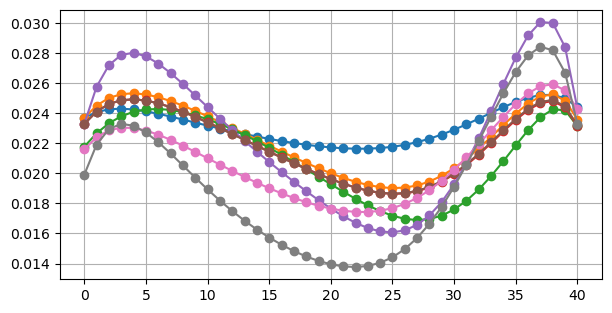

In [13]:
x, u, f, nx, nu, x_steady = sparse_system()

T = 1.0  # control horizon [s]
N = 40  # Number of control intervals
dt = T / N  # length of 1 control interval [s]

intg = cas_integrator(x, u, f, dt, solver='collocation')

# Collocation scheme
d = 3  # degree
scheme = 'radau'
tau = cas.collocation_points(d, scheme)

opti, X, U = ocp_direct_collocation_coeffs(
    f, nx, nu, N, dt, d, tau, x_steady
)
sol = opti.solve()
Xsol = sol.value(X)

plt.figure(figsize=(7, 3.5))
plt.plot(Xsol.T, 'o-')
plt.grid()
plt.show()

assert_array_almost_equal(
    sol.value(X[:, -1]), 
    [0.0243962, 0.02357921, 0.02313442, 0.02312336, 0.02429731, 0.02319165, 0.02428098, 0.02328023]
)

In [14]:
# CPU timing
timing_experiments["Direct collocation coeffs"] = process_timing(sol)
timing_experiments.round(3)

,MS with RK intg,MS with collocation intg,Direct collocation Pi,Direct collocation coeffs
t_proc_callback_fun,0.000,0.000,0.000,0.000
t_proc_nlp_f,0.000,0.000,0.000,0.000
t_proc_nlp_g,0.004,0.068,0.009,0.003
t_proc_nlp_grad,0.000,0.000,0.000,0.000
t_proc_nlp_grad_f,0.000,0.000,0.000,0.000
t_proc_nlp_hess_l,0.081,0.377,0.050,0.004
t_proc_nlp_jac_g,0.034,0.208,0.180,0.023
t_proc_total,0.173,0.710,0.474,0.261


### 1.6. Inspect the constraint Jacobian

Inspect the sparsity of the constraint Jacobian. Where do coefficients come from?

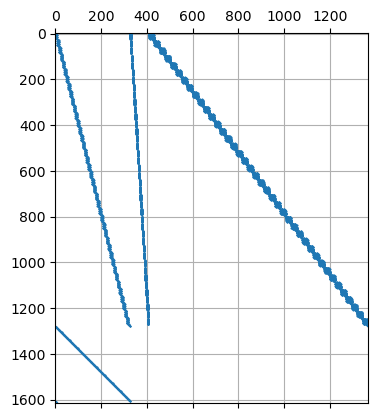

In [15]:
constraints_jac = sol.value(cas.jacobian(opti.g, opti.x))

plt.figure()
plt.spy(sol.value(constraints_jac), markersize=0.5)
plt.grid()
plt.show()

Constraints Jacobian
- Columns, decision variables:
  - states
  - controls
  - auxilliary states (collocation points)
- Rows, dynamic constraints:
  - time derivatives (rhs of ode)
  - continuity constraints 

Zoom in

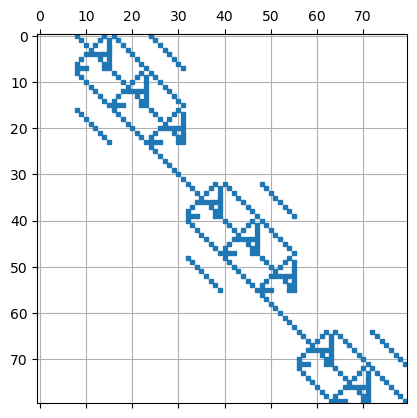

In [16]:
plt.figure()
plt.spy(constraints_jac[:80, 400:480], markersize=3)
plt.grid()
plt.show()

Note that this 'A' pattern comes directly from the $\mathbf{A}$ matrix in the continuous-time system dynamics

Comments
 - In many engineered systems, with a lot of states, there is a lot of sparsity available in the system dynamics
 - Direct collocation method preserves this sparsity
 - Tightly-connected system - solar system - all planets interacts
 - Engineering systems - lumped bodies - not all interact.
 - Even though the system was much bigger with constraints than the multiple shooting, it still solved sparser because the solver was able to handle the sparsity efficiently.





## Summary - Benefits of Direct Collocation

Benefits of collocation:
 - Preserve system sparsity (if present) - this is lost in multiple shooting as the integration step usually introduces interactions between all states
 - Implicit integrator scheme -> stable, can handle stiff systems (see definitions below)
 - Simultaneous simulation and optimization: no need to accurately
   integrate early in the optimization process
 - Trivial to extend to DAE - just have to add extra constraints on states and controls (provided it is low index)
 - Excellent opportunity for providing initial guesses (same is in multiple shooting)
 - Lifting of intermediate variables -> more linear (smilar to multiple shooting vs single shooting).  Non-linearities of the RK are also reduced.  Only non-linearity is the system dynamics (dotPi is linear).


From Wikipedia:
> In mathematics, a stiff equation is a differential equation for which certain numerical methods for solving the equation are numerically unstable, unless the step size is taken to be extremely small. It has proven difficult to formulate a precise definition of stiffness, but the main idea is that the equation includes some terms that can lead to rapid variation in the solution.


From Mathworks:
> An ordinary differential equation problem is stiff if the solution being sought is varying slowly, but there are nearby solutions that vary rapidly, so the numerical method must take small steps to obtain satisfactory results.

## 2. Lifting Runge-Kutta

### 2.1. Use an explicit Runge-Kutta formula inside the gap-closing loop

Start again from the original implementation sparse system. Replace the call to discretized
system F with an explicit Runge-Kutta formula inside the gap-closing loop:

```python
for k in range(N):
    x = X[:,k]
    u = U[:,k]
    k1 = f(x, u)
    k2 = f(x + dt/2 * k1, u)
    k3 = f(x + dt/2 * k2, u)
    k4 = f(x + dt * k3, u)
    xf = x+dt/6*(k1 +2*k2 +2*k3 +k4)
    opti.subject_to(X[:,k+1]==xf)
```

Verify that this change does not alter the optimal solution.

Inspect the constraint Jacobian sparsity of this transcription, and compare it to the reference implementation. Is the part related to the discretized dynamics sparse or dense?

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3488
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     2217

Total number of variables............................:      409
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      328
Total number of inequality constraints...............:      328
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      328
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1639980e-03 6.94e-18 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

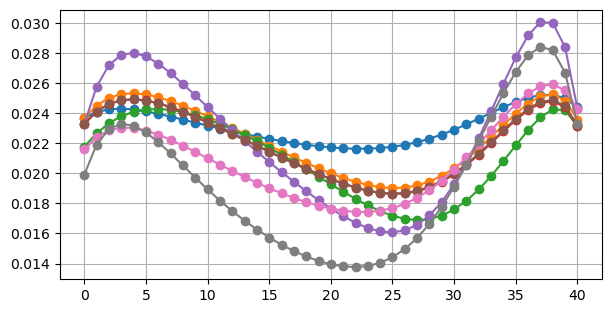

In [17]:
x, u, f, nx, nu, x_steady = sparse_system()

T = 1.0  # control horizon [s]
N = 40  # Number of control intervals
dt = T / N  # length of 1 control interval [s]

intg = explicit_integrator_rk4(x, u, f, dt)

opti, X, U = ocp_multiple_shooting(nx, nu, N, intg, x_steady)
sol = opti.solve()
Xsol = sol.value(X)

plt.figure(figsize=(7, 3.5))
plt.plot(Xsol.T, 'o-')
plt.grid()
plt.show()

assert_array_almost_equal(
    sol.value(X[:, -1]), 
    [0.0243962, 0.02357921, 0.02313442, 0.02312336, 0.02429731, 0.02319165, 0.02428098, 0.02328023]
)

In [18]:
# CPU timing
timing_experiments["Explicit RK"] = process_timing(sol)
timing_experiments.round(3)

,MS with RK intg,MS with collocation intg,Direct collocation Pi,Direct collocation coeffs,Explicit RK
t_proc_callback_fun,0.000,0.000,0.000,0.000,0.000
t_proc_nlp_f,0.000,0.000,0.000,0.000,0.000
t_proc_nlp_g,0.004,0.068,0.009,0.003,0.002
t_proc_nlp_grad,0.000,0.000,0.000,0.000,0.000
t_proc_nlp_grad_f,0.000,0.000,0.000,0.000,0.000
t_proc_nlp_hess_l,0.081,0.377,0.050,0.004,0.029
t_proc_nlp_jac_g,0.034,0.208,0.180,0.023,0.020
t_proc_total,0.173,0.710,0.474,0.261,0.105


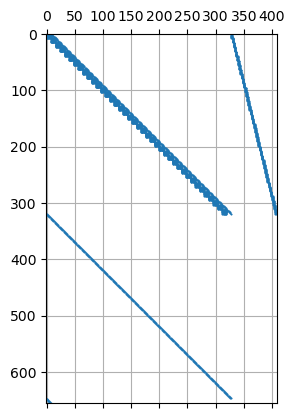

In [19]:
constraints_jac = sol.value(cas.jacobian(opti.g, opti.x))

plt.figure()
plt.spy(sol.value(constraints_jac), markersize=0.5)
plt.grid()
plt.show()

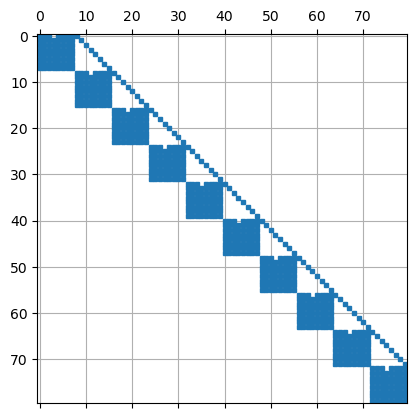

In [20]:
plt.figure()
plt.spy(constraints_jac[:80, 0:80], markersize=3)
plt.grid()
plt.show()

Comments
 - The sparsity is gone
 - The part of the constraints Jacobian related to the discretized dynamics is not sparse as it was with the direct collocation method.
 - (With explicit Euler it would still be sparse but the higher order terms destroy it).

### 2.2. Lift the intermediate expressions

Lift the intermediate expressions `k1`, `k2`, `k3`, `k4`: create decision variables for them, and replace assignments with constraints.
Does this give the same numerical result? Is the part related to the discretized dynamics sparse or dense?

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    11928
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     2337

Total number of variables............................:     1689
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1608
Total number of inequality constraints...............:      328
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      328
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1639980e-03 3.33e-16 3.61e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

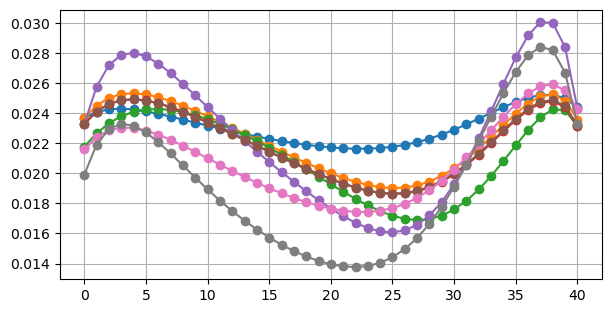

In [21]:
x, u, f, nx, nu, x_steady = sparse_system()

T = 1.0  # control horizon [s]
N = 40  # Number of control intervals
dt = T / N  # length of 1 control interval [s]

opti, X, U = ocp_lifted_rk(f, nx, nu, N, dt, x_steady)
sol = opti.solve()
Xsol = sol.value(X)

plt.figure(figsize=(7, 3.5))
plt.plot(Xsol.T, 'o-')
plt.grid()
plt.show()

assert_array_almost_equal(
    sol.value(X[:, -1]), 
    [0.0243962, 0.02357921, 0.02313442, 0.02312336, 0.02429731, 0.02319165, 0.02428098, 0.02328023]
)

In [22]:
# CPU timing
timing_experiments["Lifted RK"] = process_timing(sol)
timing_experiments.round(3)

,MS with RK intg,MS with collocation intg,Direct collocation Pi,Direct collocation coeffs,Explicit RK,Lifted RK
t_proc_callback_fun,0.000,0.000,0.000,0.000,0.000,0.000
t_proc_nlp_f,0.000,0.000,0.000,0.000,0.000,0.000
t_proc_nlp_g,0.004,0.068,0.009,0.003,0.002,0.003
t_proc_nlp_grad,0.000,0.000,0.000,0.000,0.000,0.000
t_proc_nlp_grad_f,0.000,0.000,0.000,0.000,0.000,0.000
t_proc_nlp_hess_l,0.081,0.377,0.050,0.004,0.029,0.008
t_proc_nlp_jac_g,0.034,0.208,0.180,0.023,0.020,0.034
t_proc_total,0.173,0.710,0.474,0.261,0.105,0.211


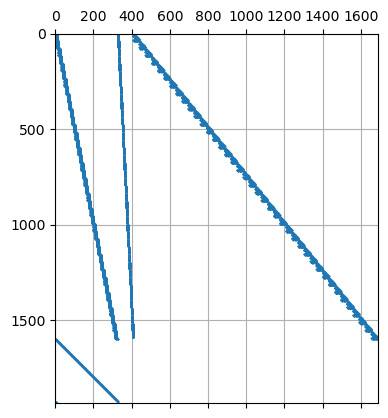

In [23]:
constraints_jac = sol.value(cas.jacobian(opti.g, opti.x))

plt.figure()
plt.spy(sol.value(constraints_jac), markersize=0.5)
plt.grid()
plt.show()

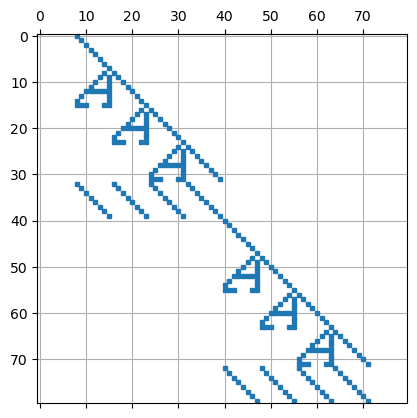

In [24]:
plt.figure()
plt.spy(constraints_jac[:80, 400:480], markersize=3)
plt.grid()
plt.show()

Comments
 - Numerical result appears to be the same (within tolerances)
 - Constraints Jacobian also appears to be sparse and the computation is fast.
 - The method of 'lifting' the intermediate variables of the integration scheme to the non-linear problem solver is not restructed to implicit methods such as collocation.
 - It has some benefits but it is not an implicit method.  "Not sure if it is useful in practice but it is interesting that you can get a similar result to the direct collocation method."